# Hypothesis Testing

In this notebook we demonstrate formal hypothesis testing using the NHANES data.

It is important to note that the NHANES data are a "complex survey".  The data are not an independent and representative sample from the target population.  Proper analysis of complex survey data should make use of additional information about how the data were collected.  Since complex survey analysis is a somewhat specialized topic, we ignore this aspect of the data here, and analyze the NHANES data as if it were an independent and identically distributed sample from a population.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg') # workaround, there may be a better way
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats.distributions as dist

Below we read the data, and convert some of the integer codes to text values.

In [2]:
url = "nhanes_2015_2016.csv"
da = pd.read_csv(url)

da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})

In [3]:
da["SMQ020x"].head()

0    Yes
1    Yes
2    Yes
3     No
4     No
Name: SMQ020x, dtype: object

In [4]:
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})

da["RIAGENDRx"].head()

0      Male
1      Male
2      Male
3    Female
4    Female
Name: RIAGENDRx, dtype: object

In [5]:
da["gender"] = da.RIAGENDR.replace({1:"Male", 2:"Female"})
da["gender"]

0         Male
1         Male
2         Male
3       Female
4       Female
5       Female
6         Male
7       Female
8         Male
9         Male
10        Male
11        Male
12      Female
13      Female
14        Male
15      Female
16      Female
17      Female
18      Female
19      Female
20        Male
21      Female
22      Female
23      Female
24        Male
25      Female
26        Male
27      Female
28        Male
29      Female
         ...  
5705      Male
5706      Male
5707    Female
5708    Female
5709      Male
5710    Female
5711      Male
5712    Female
5713      Male
5714      Male
5715    Female
5716    Female
5717      Male
5718      Male
5719    Female
5720      Male
5721    Female
5722    Female
5723    Female
5724    Female
5725      Male
5726      Male
5727    Female
5728      Male
5729      Male
5730    Female
5731      Male
5732    Female
5733      Male
5734    Female
Name: gender, Length: 5735, dtype: object

### Hypothesis Tests for One Proportion

The most basic hypothesis test may be the one-sample test for a proportion.  This test is used if we have specified a particular value as the null value for the proportion, and we wish to assess if the data are compatible with the true parameter value being equal to this specified value.  One-sample tests are not used very often in practice, because it is not very common that we have a specific fixed value to use for comparison. For illustration, imagine that the rate of lifetime smoking in another country was known to be 40%, and we wished to assess whether the rate of lifetime smoking in the US were different from 40%.  In the following notebook cell, we carry out the (two-sided) one-sample test that the population proportion of smokers is 0.4, and obtain a p-value of 0.43.  This indicates that the NHANES data are compatible with the proportion of (ever) smokers in the US being 40%. 

In [6]:
x = da.SMQ020x.dropna() == "Yes"

In [7]:
p = x.mean()

In [8]:
p

0.4050655021834061

In [9]:
se = np.sqrt(.4 * (1 - .4)/ len(x))
se

0.00647467353462031

In [10]:
test_stat = (p - 0.4) / se
test_stat

0.7823563854332805

In [11]:
pvalue = 2 * dist.norm.cdf(-np.abs(test_stat))
print(test_stat, pvalue)

0.7823563854332805 0.4340051581348052


The following cell carries out the same test as performed above using the Statsmodels library.  The results in the first (default) case below are slightly different from the results obtained above because Statsmodels by default uses the sample proportion instead of the null proportion when computing the standard error.  This distinction is rarely consequential, but we can specify that the null proportion should be used to calculate the standard error, and the results agree exactly with what we calculated above.  The first two lines below carry out tests using the normal approximation to the sampling distribution of the test statistic, and the third line below carries uses the exact binomial sampling distribution.  We can see here that the p-values are nearly identical in all three cases. This is expected when the sample size is large, and the proportion is not close to either 0 or 1.

In [12]:
# Normal approximation with estimated propotion in SE
esti_pro = sm.stats.proportions_ztest(x.sum(), len(x), 0.4)

# Normal approximation with null propotion in SE
null_pro = sm.stats.proportions_ztest(x.sum(), len(x), 0.4, prop_var=0.4)

# Exact binomial p-value
binomial_pvalue = sm.stats.binom_test(x.sum(), len(x), 0.4)

(esti_pro, null_pro, binomial_pvalue)

((0.7807518954896244, 0.43494843171868214),
 (0.7823563854332805, 0.4340051581348052),
 0.4340360854459431)

In [13]:
sm.stats.binom_test(x.sum(), len(x), 0.4)

0.4340360854459431

### Hypothesis Tests for Two Proportions

Comparative tests tend to be used much more frequently than tests comparing one population to a fixed value.  A two-sample test of proportions is used to assess whether the proportion of individuals with some trait differs between two sub-populations.  For example, we can compare the smoking rates between females and males. Since smoking rates vary strongly with age, we do this in the subpopulation of people between 20 and 25 years of age.  In the cell below, we carry out this test without using any libraries, implementing all the test procedures covered elsewhere in the course using Python code.  We find that the smoking rate for men is around 10 percentage points greater than the smoking rate for females, and this difference is statistically significant (the p-value is around 0.01).

In [14]:
dx = da[["SMQ020x", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx["RIDAGEYR"] >= 20) & (dx["RIDAGEYR"] <= 25),:]

dx.head()

,SMQ020x,RIDAGEYR,RIAGENDRx
6,Yes,22,Male
17,No,24,Female
26,Yes,22,Male
38,No,20,Female
40,Yes,24,Male


Summarize the data by calculating the proportion of yes responses and the sample size

In [15]:
p = dx.groupby("RIAGENDRx")["SMQ020x"].agg([lambda z: np.mean(z == "Yes"), "size"])
p.columns = ["Smoke", "N"]
print(p)

              Smoke    N
RIAGENDRx               
Female     0.238971  272
Male       0.341270  252


Essentially the same test as above can be conducted by converting the "Yes"/"No" responses to numbers (Yes=1, No=0) and conducting a two-sample t-test, as below:

In [16]:
p_comb = (dx.SMQ020x == "Yes").mean()
va = p_comb * (1 - p_comb)

se = np.sqrt(va * (1 / p.N.Female + 1 / p.N.Male))

In [17]:
(p_comb, va, se)

(0.2881679389312977, 0.2051271779033856, 0.039599757248262944)

In [18]:
test_stat = (p.Smoke.Female - p.Smoke.Male) / se
p_value = 2 * dist.norm.cdf(-np.abs(test_stat))
(test_stat, p_value)

(-2.5833303066279414, 0.009785159057508375)

In [19]:
dx_females = dx.loc[dx.RIAGENDRx == "Female", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_females.head()

17     0
38     0
46     0
69     1
102    1
Name: SMQ020x, dtype: int64

In [20]:
dx_males = dx.loc[dx.RIAGENDRx == "Male", "SMQ020x"].replace({"Yes": 1, "No": 0})
dx_males.head()

6     1
26    1
40    1
48    0
96    0
Name: SMQ020x, dtype: int64

In [21]:
sm.stats.ttest_ind(dx_females, dx_males)

(-2.5949731446269344, 0.00972590232121254, 522.0)

### Hypothesis Tests Comparing Means

Tests of means are similar in many ways to tests of proportions.  Just as with proportions, for comparing means there are one and two-sample tests, z-tests and t-tests, and one-sided and two-sided tests.  As with tests of proportions, one-sample tests of means are not very common, but we illustrate a one sample test in the cell below.  We compare systolic blood pressure to the fixed value 120 (which is the lower threshold for "pre-hypertension"), and find that the mean is significantly different from 120 (the point estimate of the mean is 126).

In [22]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx.head()

,BPXSY1,RIDAGEYR,RIAGENDRx
0,128.0,62,Male
1,146.0,53,Male
2,138.0,78,Male
3,132.0,56,Female
4,100.0,42,Female


In [23]:
dx = dx.loc[(dx.RIDAGEYR >= 40) & (dx.RIDAGEYR <= 50) & (dx.RIAGENDRx == "Male"), :]
dx.head()

,BPXSY1,RIDAGEYR,RIAGENDRx
10,144.0,46,Male
11,116.0,45,Male
20,110.0,49,Male
42,128.0,42,Male
51,118.0,50,Male


In [24]:
print(dx.BPXSY1.mean())

125.86698337292161


In [25]:
sm.stats.ztest(dx.BPXSY1, value=120)

(7.469764137102597, 8.033869113167905e-14)

In the cell below, we carry out a formal test of the null hypothesis that the mean blood pressure for women between the ages of 50 and 60 is equal to the mean blood pressure of men between the ages of 50 and 60.  The results indicate that while the mean systolic blood pressure for men is slightly greater than that for women (129 mm/Hg versus 128 mm/Hg), this difference is not statistically significant. 

There are a number of different variants on the two-sample t-test. Two often-encountered variants are the t-test carried out using the t-distribution, and the t-test carried out using the normal approximation to the reference distribution of the test statistic, often called a z-test.  Below we display results from both these testing approaches.  When the sample size is large, the difference between the t-test and z-test is very small.  

In [26]:
dx = da[["BPXSY1", "RIDAGEYR", "RIAGENDRx"]].dropna()
dx = dx.loc[(dx.RIDAGEYR >= 50) & (dx.RIDAGEYR <= 60), :]
dx.head()

,BPXSY1,RIDAGEYR,RIAGENDRx
1,146.0,53,Male
3,132.0,56,Female
9,178.0,56,Male
15,134.0,57,Female
19,136.0,54,Female


In [27]:
bpx_female = dx.loc[dx.RIAGENDRx=="Female", "BPXSY1"]
bpx_male = dx.loc[dx.RIAGENDRx=="Male", "BPXSY1"]
print(bpx_female.mean(), bpx_male.mean())

127.92561983471074 129.23829787234044


In [28]:
print(sm.stats.ztest(bpx_female, bpx_male))

(-1.105435895556249, 0.2689707570859362)


In [29]:
print(sm.stats.ttest_ind(bpx_female, bpx_male))

(-1.105435895556249, 0.26925004137768577, 952.0)


Another important aspect of two-sample mean testing is "heteroscedasticity", meaning that the variances within the two groups being compared may be different. While the goal of the test is to compare the means, the variances play an important role in calibrating the statistics (deciding how big the mean difference needs to be to be declared statisitically significant). In the NHANES data, we see that there are moderate differences between the amount of variation in BMI for females and for males, looking within 10-year age bands. In every age band, females having greater variation than males. 

RIAGENDRx    Female      Male
agegrp                       
(18, 30]   7.745893  6.649440
(30, 40]   8.315608  6.622412
(40, 50]   8.076195  6.407076
(50, 60]   7.575848  5.914373
(60, 70]   7.604514  5.933307
(70, 80]   6.284968  4.974855


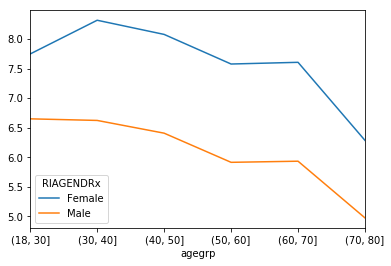

In [30]:
dx = da[["BMXBMI", "RIDAGEYR", "RIAGENDRx"]].dropna()
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 30, 40, 50, 60, 70, 80])
print(da.groupby(["agegrp", "RIAGENDRx"])["BMXBMI"].agg(np.std).unstack())
da.groupby(["agegrp", "RIAGENDRx"])["BMXBMI"].agg(np.std).unstack().plot()

The standard error of the mean difference (e.g. mean female blood pressure minus mean mal blood pressure) can be estimated in at least two different ways. In the statsmodels library, these approaches are referred to as the "pooled" and the "unequal" approach to estimating the variance. If the variances are equal (i.e. there is no heteroscedasticity), then there should be little difference between the two approaches. Even in the presence of moderate heteroscedasticity, as we have here, we can see that the results for the two differences are quite similar. Below we have a loop that considers each 10-year age band and assesses the evidence for a difference in mean BMI for women and for men. The results printed in each row of output are the test-statistic and p-value. 

In [31]:
da.groupby("agegrp").sum()

,SEQN,ALQ101,ALQ110,ALQ130,SMQ020,RIAGENDR,RIDAGEYR,RIDRETH1,DMDCITZN,DMDEDUC2,...,BPXSY2,BPXDI2,BMXWT,BMXHT,BMXBMI,BMXLEG,BMXARML,BMXARMC,BMXWAIST,HIQ210
agegrp,,,,,,,,,,,,,,,,,,,,,
"(18, 30]",102264247,1332.0,502.0,2497.0,1985,1762,28327,3569,1405.0,3802.0,...,126650.0,72924.0,89500.5,191387.8,31695.5,44086.2,41013.0,35944.4,102002.7,1579.0
"(30, 40]",82739183,1039.0,344.0,2886.0,1510,1406,32961,2849,1231.0,3309.0,...,103732.0,63304.0,77633.9,154281.1,27607.2,34462.0,32724.9,30044.7,87200.1,1265.0
"(40, 50]",79995606,1061.0,392.0,2564.0,1491,1405,41006,2869,1107.0,3183.0,...,108742.0,66458.0,76051.7,149276.5,27348.4,32786.4,31754.1,29263.5,85982.2,1354.0
"(50, 60]",81949452,1081.0,369.0,1401.0,1397,1394,51257,2794,1062.0,3140.0,...,115340.0,65674.0,76430.7,152565.0,27510.0,33736.7,33488.0,30181.9,91193.8,1491.0
"(60, 70]",77808167,1141.0,470.0,3093.0,1310,1319,57227,2522,976.0,2839.0,...,113240.0,58552.0,71130.5,142759.9,26100.9,30603.0,31244.4,27863.3,86134.5,1564.0
"(70, 80]",72064990,1098.0,521.0,619.0,1265,1222,62408,2436,872.0,2567.0,...,108250.0,48910.0,60466.3,130359.4,22646.2,25311.8,26661.1,22450.2,70865.6,1577.0


In [35]:
for k, v in da.groupby("agegrp"):
    bmi_female = v.loc[v.RIAGENDRx=="Female", "BMXBMI"].dropna()
    bmi_female = sm.stats.DescrStatsW(bmi_female)
    bmi_male = v.loc[v.RIAGENDRx=="Male", "BMXBMI"].dropna()
    bmi_male = sm.stats.DescrStatsW(bmi_male)
    print(k)
    print("pooled: ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='pooled'))
    print("unequal: ", sm.stats.CompareMeans(bmi_female, bmi_male).ztest_ind(usevar='unequal'),"\n")

(18, 30]
pooled:  (1.7026932933643388, 0.08862548061449649)
unequal:  (1.7174610823927268, 0.08589495934713022) 

(30, 40]
pooled:  (1.4378280405644916, 0.1504828511464818)
unequal:  (1.4437869620833494, 0.14879891057892475) 

(40, 50]
pooled:  (2.8933761158070186, 0.003811246059501354)
unequal:  (2.9678691663536725, 0.0029987194174035366) 

(50, 60]
pooled:  (3.362108779981367, 0.0007734964571391746)
unequal:  (3.375494390173923, 0.0007368319423226574) 

(60, 70]
pooled:  (3.6172401442432753, 0.000297761021031936)
unequal:  (3.62848309454456, 0.0002850914147149227) 

(70, 80]
pooled:  (2.926729252512258, 0.0034254694144858636)
unequal:  (2.937779886769224, 0.003305716331519299) 

